# Model creation playground

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import itertools
from pickle import dump
import json
import sys
import string

import keras
from keras import layers
from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Explore the input file

In [2]:
# We will just use messages from customer service to train our model
messages_from_customer_service = []

with open('input_files/conversations.json') as input_file:
    input_data = json.load(input_file)
print("There are {} text messages in the json file!\n".format(input_data['NumTextMessages']))

for issue in input_data['Issues']:
    if(issue['IssueId']==1):
        print("Issue id 1:")
        pprint(issue)
        print("\n")
    for message in issue["Messages"]:
        if not message['IsFromCustomer']:
            messages_from_customer_service.append(message['Text'].split())
print("There are {} customer service messages!\n".format(len(messages_from_customer_service)))                
print("First message from customer service:")
print(messages_from_customer_service[0])

There are 22264 text messages in the json file!

Issue id 1:
{'CompanyGroupId': 1,
 'IssueId': 1,
 'Messages': [{'IsFromCustomer': True,
               'Text': "Hi! I placed an order on your website and I can't find "
                       'the tracking number. Can you help me find out where my '
                       'package is?'},
              {'IsFromCustomer': True,
               'Text': 'I think I used my email address to log in.'}]}


There are 11060 customer service messages!

First message from customer service:
['Hello', 'Werner', 'how', 'may', 'I', 'help', 'you', 'today?']


## Vectorizing prefix and target

In [3]:
# Flatten the list
flattened_messages_from_customer_service = []        
for message in messages_from_customer_service:
    for word in message:
        flattened_messages_from_customer_service.append(word)

# Create a text corpus
text_corpus = " ".join(flattened_messages_from_customer_service)

In [4]:
# List of unique characters in the corpus
unique_chars = sorted(list(set(text_corpus))) #sorted(string.printable)

unique_chars_length = len(unique_chars)
print("There are {} unique characters in the corpus:".format(unique_chars_length))
print(unique_chars)

# Assign a unique index to each unique character
unique_chars_mapping = dict((char, i) for i, char in enumerate(unique_chars))

# Save the mapping
dump(unique_chars_mapping, open('saved_models/unique_chars_mapping.pkl', 'wb'))

There are 87 unique characters in the corpus:
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '}']


In [5]:
# Get sequence of max_len characters
max_len = 25

# Sample new sequence every sequence_step characters
sequence_step = 1

# Lists to hold the prefixes and targets
prefix_sequences = []
target_character = []
for i in range (0, len(text_corpus) - max_len, sequence_step):
    prefix_sequences.append(text_corpus[i: i + max_len])
    target_character.append(text_corpus[i + max_len])
print("There are {} prefixes and {} targets, respectively.".format(len(prefix_sequences), 
                                                                   len(target_character)))

There are 651003 prefixes and 651003 targets, respectively.


In [6]:
prefix_sequences_encoded = []
for sequence in prefix_sequences:
    prefix_sequences_encoded.append([unique_chars_mapping[char] for char in sequence])
prefix_sequences_encoded = np.array(prefix_sequences_encoded)

target_character_encoded = []
for char in target_character:
    target_character_encoded.append(unique_chars_mapping[char])
target_character_encoded = np.array(target_character_encoded)

In [8]:
X = [to_categorical(x, num_classes=unique_chars_length) for x in prefix_sequences_encoded]
X = np.array(X)

y = to_categorical(target_character_encoded, num_classes=unique_chars_length)

## Split data into training, validation, test sets (80/10/10)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=99)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=99)

print("The training set has %d samples." % len(X_train))
print("The validation set has %d samples." % len(X_val))
print("The test set has %d samples." % len(X_test))

NameError: name 'X' is not defined

## Building the model

In [9]:
model = keras.models.Sequential()
model.add(layers.LSTM(128,
                      dropout=0.1,
                      recurrent_dropout=0.1,
                      input_shape=(max_len, unique_chars_length)))
model.add(layers.Dense(unique_chars_length, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               110592    
_________________________________________________________________
dense_1 (Dense)              (None, 87)                11223     
Total params: 121,815.0
Trainable params: 121,815
Non-trainable params: 0.0
_________________________________________________________________


## Compile the code

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.01), metrics=['acc'])

In [11]:
# Evaluate the test accuracy before training
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (before training): %.2f%%' % accuracy)

Test accuracy of the model (before training): 0.71%


Epoch 00000: val_loss improved from inf to 0.99904, saving model to saved_models/model_weights.hdf5
Epoch 00001: val_loss improved from 0.99904 to 0.92321, saving model to saved_models/model_weights.hdf5
Epoch 00002: val_loss improved from 0.92321 to 0.90143, saving model to saved_models/model_weights.hdf5
Epoch 00003: val_loss improved from 0.90143 to 0.88214, saving model to saved_models/model_weights.hdf5
Epoch 00004: val_loss improved from 0.88214 to 0.87854, saving model to saved_models/model_weights.hdf5
Epoch 00005: val_loss improved from 0.87854 to 0.87438, saving model to saved_models/model_weights.hdf5
Epoch 00006: val_loss improved from 0.87438 to 0.87117, saving model to saved_models/model_weights.hdf5
Epoch 00007: val_loss improved from 0.87117 to 0.86715, saving model to saved_models/model_weights.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve

Epoch 00011: reduci

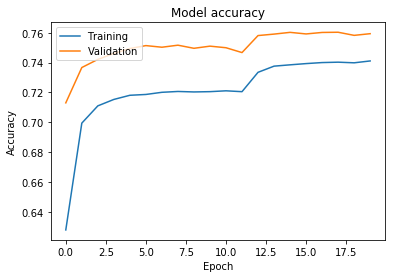

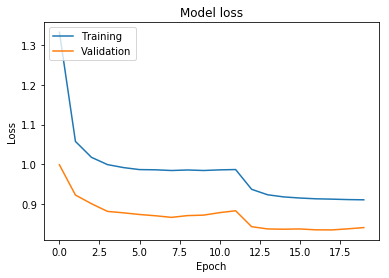

In [12]:
epochs = 20
batch_size = 128

# Stop training when a monitored quantity has stopped improving after 20 epochs
early_stop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

# Save the best model after every epoch
check_point = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                             validation_data=(X_val, y_val), 
                             callbacks=[check_point, early_stop, reduce_lr])


# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_accuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_loss.pdf', bbox_inches='tight')
plt.show()

# Save the model
model.save('saved_models/model.hdf5')

In [13]:
# Evaluate the test accuracy after the training
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.2f%%' % accuracy)

Test accuracy of the model (after training): 76.12%


## Test the real time auto-complete

In [14]:
model_test = load_model('saved_models/model.hdf5')
model_test.load_weights('saved_models/model_weights.hdf5')

In [15]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [16]:
from keras.preprocessing.sequence import pad_sequences

break_at_char = ["?", ".", "!"]

test_text = "How may I help "
temperature = 0.2

print('Test text:', test_text)

outputs = [test_text]
for _ in range(50):
    test_text_encoded = [unique_chars_mapping[char] for char in test_text]
    
    # Truncate sequences to a fixed length
    test_text_encoded = pad_sequences([test_text_encoded], maxlen=max_len, truncating='pre')
    
    # One hot encode
    test_text_encoded = to_categorical(test_text_encoded, num_classes=unique_chars_length)
    test_text_encoded = test_text_encoded.reshape(1, test_text_encoded.shape[0], test_text_encoded.shape[1])
    
    preds = model_test.predict(test_text_encoded, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = unique_chars[next_index]
    outputs.append(next_char)
    
    test_text += next_char
    if next_char in break_at_char:
        break
            
print("".join(outputs))

Test text: That is fine if you want
That is fine if you want the tickets of your payment was declined by the d
